---

<h1><center> ↓↓ CODING ↓↓ </center></h1>

---

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
random.seed(3)

In [126]:
NUM_NODES = 50
RUSH_HOURS = [(7, 9), (16, 19)]  # Representing 7h-9h and 16h-19h

In [127]:
# Function to determine if a given hour is within rush hours
def is_rush_hour(hour):
    return any(start <= hour < end for start, end in RUSH_HOURS)

In [128]:
G = nx.complete_graph(NUM_NODES)

In [129]:
for (i, j) in G.edges:
    base_time = random.randint(60, 180)  # Random base travel time in minutes
    off_peak_time = base_time
    rush_hour_time = base_time + (random.randint(20,30) * base_time) / 100
    G.edges[i, j]['off_peak_time'] = off_peak_time
    G.edges[i, j]['rush_hour_time'] = rush_hour_time

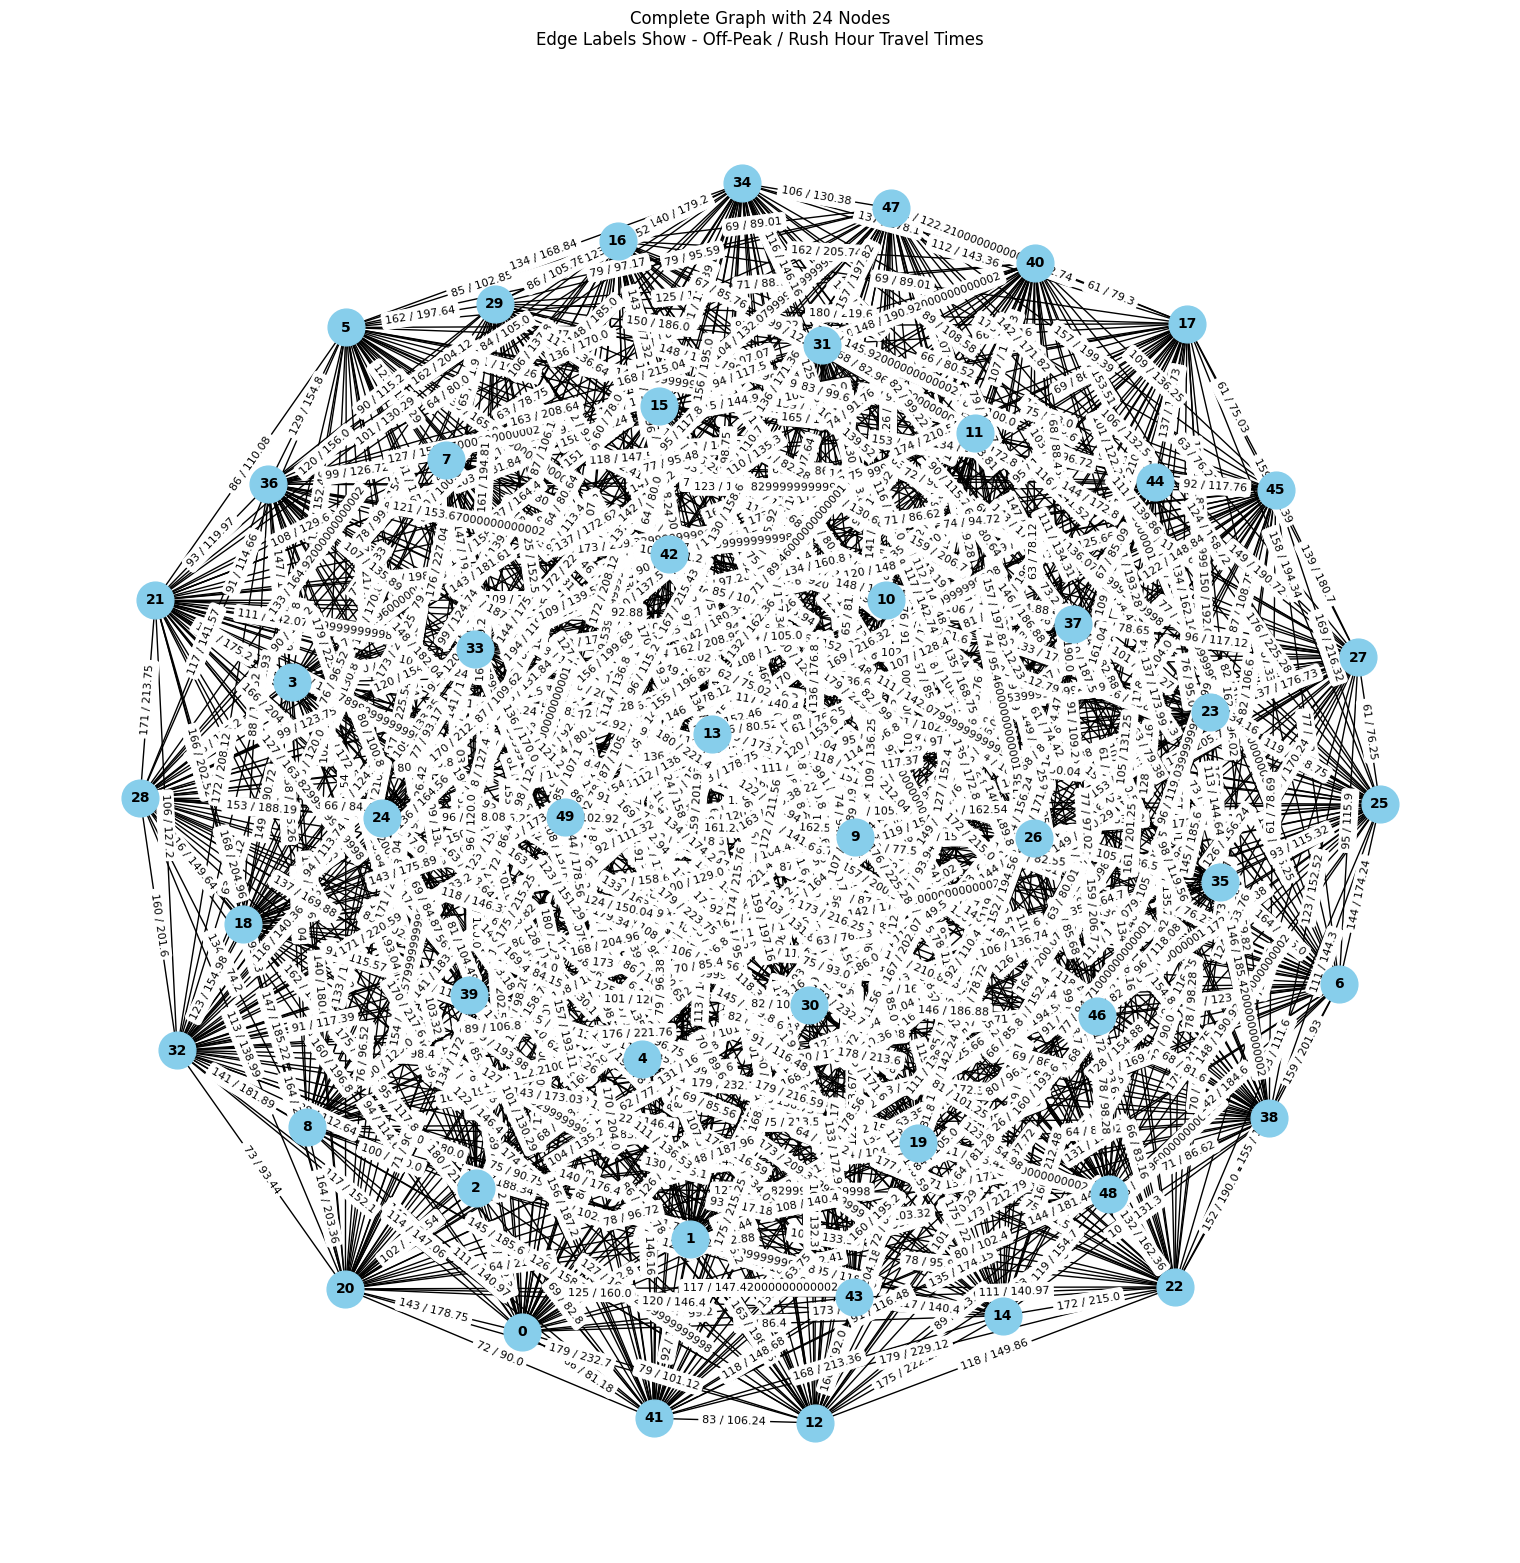

In [130]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, seed=42)  # Position the nodes using a spring layout
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight="bold")

# Create labels for each edge showing the off-peak travel time
edge_labels = {(i, j): f"{G.edges[i, j]['off_peak_time']} / {G.edges[i, j]['rush_hour_time']}" for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Complete Graph with 24 Nodes\nEdge Labels Show - Off-Peak / Rush Hour Travel Times")
plt.show()

In [131]:
# Function to get travel time based on hour of the day
def get_travel_time(i, j, hour):
    """Returns travel time for edge (i, j) based on the hour."""
    edge_data = G.get_edge_data(i, j)
    if edge_data is None:
        raise ValueError(f"No edge exists between nodes {i} and {j}")
    
    if is_rush_hour(hour):
        return edge_data['rush_hour_time']
    else:
        return edge_data['off_peak_time']

In [132]:
# Example: Print travel time between two nodes (e.g., nodes 0 and 1) at different hours
print(f"Travel time between nodes 0 and 1 at 8h (rush hour): {get_travel_time(0, 1, 8)} mins")
print(f"Travel time between nodes 0 and 1 at 10h (off-peak hour): {get_travel_time(0, 1, 10)} mins")
print(f"Travel time between nodes 0 and 1 at 17h (rush hour): {get_travel_time(0, 1, 17)} mins")
print(f"Travel time between nodes 0 and 1 at 20h (off-peak hour): {get_travel_time(0, 1, 20)} mins")

Travel time between nodes 0 and 1 at 8h (rush hour): 172.8 mins
Travel time between nodes 0 and 1 at 10h (off-peak hour): 135 mins
Travel time between nodes 0 and 1 at 17h (rush hour): 172.8 mins
Travel time between nodes 0 and 1 at 20h (off-peak hour): 135 mins


# Genetic Algorithm

In [133]:
import logging
import time
import numpy as np

In [134]:
# GA Parameters
POP_SIZE = 200         # Population size
NUM_GENERATIONS = 100  # Maximum number of generations
MUTATION_RATE = 0.1    # Mutation rate
TOURNAMENT_SIZE = 5    # Tournament size for selection
ELITISM_RATE = 0.2     # Percentage of elite solutions to keep
STAGNATION_LIMIT = 30  # Generations to wait without improvement

In [135]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

In [136]:
# Function to calculate the fitness of a route
def calculate_route_time(route, start_hour):
    """Calculate the total travel time for a route considering time-dependent traffic."""
    total_time = 0
    current_hour = start_hour
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        travel_time = get_travel_time(u, v, current_hour)
        total_time += travel_time
        current_hour = (current_hour + (travel_time // 60)) % 24  # Update hour, wrapping to 24-hour format
    
    # Return back to the depot (node 0)
    if route[-1] == 0:
        travel_time = 0  # No time to return to itself
    else:
        travel_time = get_travel_time(route[-1], 0, current_hour)  # Get travel time from the last node to depot
    total_time += travel_time
    return total_time

In [137]:
# Initialize population
def initialize_population():
    population = []
    for _ in range(POP_SIZE):
        route = list(range(1, NUM_NODES))  # Start from 1 (exclude depot node 0)
        random.shuffle(route)
        route = [0] + route + [0]  # Complete the route to form a Hamiltonian circuit
        population.append(route)
    return population

In [138]:
# Selection using tournament selection
def tournament_selection(population, fitnesses):
    tournament = random.sample(list(zip(population, fitnesses)), TOURNAMENT_SIZE)
    tournament.sort(key=lambda x: x[1])
    return tournament[0][0]

In [139]:
# Crossover operation
def ordered_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(1, size - 1), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]
    
    # Fill in the rest with nodes from the second parent
    current_index = 0
    for node in parent2:
        if node not in child:
            # Find the next None position in the child
            while current_index < size and child[current_index] is not None:
                current_index += 1
            if current_index < size:  # Ensure we don't go out of bounds
                child[current_index] = node

    # Ensure the child starts and ends with the depot (node 0)
    child[0] = 0
    child[-1] = 0

    # Fill any remaining None values with valid nodes
    for i in range(size):
        if child[i] is None:
            # Find a valid node not already in the child
            for node in parent2:                
                if node not in child:
                    child[i] = node
                    break
    return child

In [140]:
# Mutation operation
def mutate(route):
    if random.random() < MUTATION_RATE:
        i, j = sorted(random.sample(range(1, len(route) - 1), 2))
        route[i], route[j] = route[j], route[i]

In [141]:
# Main Genetic Algorithm function
def genetic_algorithm(start_hour=0, POP_SIZE=POP_SIZE, NUM_GENERATIONS=NUM_GENERATIONS, MUTATION_RATE=MUTATION_RATE, TOURNAMENT_SIZE=TOURNAMENT_SIZE, ELITISM_RATE=ELITISM_RATE, STAGNATION_LIMIT=STAGNATION_LIMIT):
    population = initialize_population()
    fitness_history = []
    best_route, best_fitness = None, float('inf')
    stagnation_counter = 0

    for generation in range(NUM_GENERATIONS):
        # Calculate fitness for each route
        fitnesses = [calculate_route_time(route, start_hour) for route in population]
        
        # Log best fitness of the current generation
        best_gen_fitness = min(fitnesses)
        if best_gen_fitness < best_fitness:
            best_fitness = best_gen_fitness
            best_route = population[fitnesses.index(best_fitness)]
            stagnation_counter = 0
        else:
            stagnation_counter += 1
        
        ## logging.info(f"Generation {generation + 1}: Best fitness = {best_gen_fitness}")
        
        # Stopping condition for stagnation
        if stagnation_counter >= STAGNATION_LIMIT:
            break

        # Selection and Crossover
        new_population = []
        elite_size = int(ELITISM_RATE * POP_SIZE)
        elites = [population[i] for i in np.argsort(fitnesses)[:elite_size]]
        new_population.extend(elites)

        while len(new_population) < POP_SIZE:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = ordered_crossover(parent1, parent2)
            mutate(child)
            new_population.append(child)
        
        population = new_population

    return best_route, best_fitness

# Ant Colony Optimization

In [142]:
# ACO Parameters
NUM_ANTS = 50               # Number of ants per iteration
NUM_ITERATIONS = 200        # Number of iterations
EVAPORATION_RATE = 0.5      # Pheromone evaporation rate
PHEROMONE_WEIGHT = 1.0      # Weight of pheromone influence (alpha)
HEURISTIC_WEIGHT = 2.0      # Weight of heuristic influence (beta)
Q = 1000                    # Constant for pheromone deposit

In [143]:
# Initialize pheromone levels
pheromone_matrix = np.ones((NUM_NODES, NUM_NODES))

In [144]:
def heuristic(i, j, current_time):
    """Heuristic function (η), inverse of travel time."""
    travel_time = get_travel_time(i, j, current_time)
    return 1.0 / (travel_time + 1e-5)  # The small value prevents division by zero

In [145]:
def construct_solution(start_hour):
    """Constructs a route for an ant based on current pheromones and heuristics, considering time dependency."""
    unvisited = set(range(1, NUM_NODES))
    route = [0]  # Start at depot
    current_node = 0
    current_time = start_hour  # Initialize with the start hour
    
    while unvisited:
        probabilities = []
        total_pheromone_heuristic = 0
        
        for next_node in unvisited:
            travel_time = get_travel_time(current_node, next_node, current_time)
            pheromone = pheromone_matrix[current_node, next_node] ** PHEROMONE_WEIGHT
            heuristic_value = heuristic(current_node, next_node, current_time) ** HEURISTIC_WEIGHT
            probabilities.append(pheromone * heuristic_value)
            total_pheromone_heuristic += pheromone * heuristic_value
        
        # Normalize probabilities
        if total_pheromone_heuristic == 0:
            # Handle the case where there's no pheromone or heuristic information
            probabilities = [1 / len(unvisited)] * len(unvisited)  # or some other fallback
        else:
            probabilities = [p / total_pheromone_heuristic for p in probabilities]
            
        next_node = random.choices(list(unvisited), weights=probabilities)[0]
        
        # Update current time with travel time to next node
        current_time = (current_time + get_travel_time(current_node, next_node, current_time)) % 24
        
        route.append(next_node)
        unvisited.remove(next_node)
        current_node = next_node
    
    route.append(0)  # Return to depot
    return route


In [146]:
def update_pheromones(routes, fitnesses):
    global pheromone_matrix
    pheromone_matrix *= (1 - EVAPORATION_RATE)  # Apply evaporation

    # Update pheromones based on all routes
    for route, fitness in zip(routes, fitnesses):
        pheromone_deposit = 1 / fitness
        for i in range(len(route) - 1):
            u, v = route[i], route[i + 1]
            pheromone_matrix[u, v] += Q * pheromone_deposit
            pheromone_matrix[v, u] += Q * pheromone_deposit  # Symmetric update for undirected graph

In [147]:
def ant_colony_optimization(start_hour=0, NUM_ANTS=NUM_ANTS, NUM_ITERATIONS=NUM_ITERATIONS, EVAPORATION_RATE=EVAPORATION_RATE, PHEROMONE_WEIGHT=PHEROMONE_WEIGHT, HEURISTIC_WEIGHT=HEURISTIC_WEIGHT, Q=Q):
    best_route, best_fitness = None, float('inf')
    for iteration in range(NUM_ITERATIONS):
        routes = []
        fitnesses = []
        
        for _ in range(NUM_ANTS):
            route = construct_solution(start_hour)
            travel_time = calculate_route_time(route, start_hour)
            routes.append(route)
            fitnesses.append(travel_time)
        
        # Update global best solution
        iteration_best_fitness = min(fitnesses)
        if iteration_best_fitness < best_fitness:
            best_fitness = iteration_best_fitness
            best_route = routes[fitnesses.index(best_fitness)]
        
        update_pheromones(routes, fitnesses)
        
        ## logging.info(f"Iteration {iteration + 1}: Best fitness = {iteration_best_fitness}")
    
    return best_route, best_fitness

## Comparing Genetic Algorithm's Performance with Ant Colony Optimization's Performance

In [148]:
# Function to run and log GA results
def run_genetic_algorithm_comparison(start_hour):
    start_time = time.time()
    logging.info(f"\nRunning Genetic Algorithm for start hour: {start_hour}\n")
    best_route, best_time = genetic_algorithm(start_hour)
    execution_time = time.time() - start_time
    logging.info(f"GA - Start Hour: {start_hour} -> Best Route: {best_route}")
    logging.info(f"GA - Start Hour: {start_hour} -> Minimum Travel Time: {best_time} minutes")
    logging.info(f"GA - Execution Time for start hour {start_hour}: {execution_time:.2f} seconds")
    return best_route, best_time, execution_time

In [149]:
# Function to run and log ACO results
def run_ant_colony_optimization_comparison(start_hour):
    start_time = time.time()
    logging.info(f"\nRunning Ant Colony Optimization for start hour: {start_hour}\n")
    best_route, best_time = ant_colony_optimization(start_hour)
    execution_time = time.time() - start_time
    logging.info(f"ACO - Start Hour: {start_hour} -> Best Route: {best_route}")
    logging.info(f"ACO - Start Hour: {start_hour} -> Minimum Travel Time: {best_time} minutes")
    logging.info(f"ACO - Execution Time for start hour {start_hour}: {execution_time:.2f} seconds")
    return best_route, best_time, execution_time

In [150]:
# Run comparison for both algorithms across start hours 0-23
ga_results = []
aco_results = []
hours = list(range(24))

for hour in hours:
    ga_route, ga_time, ga_exec_time = run_genetic_algorithm_comparison(hour)
    aco_route, aco_time, aco_exec_time = run_ant_colony_optimization_comparison(hour)
    
    ga_results.append((ga_route, ga_time, ga_exec_time))
    aco_results.append((aco_route, aco_time, aco_exec_time))


Running Genetic Algorithm for start hour: 0

GA - Start Hour: 0 -> Best Route: [0, 7, 15, 28, 27, 18, 16, 26, 36, 44, 1, 6, 20, 39, 35, 37, 46, 38, 29, 32, 3, 14, 13, 12, 10, 5, 41, 8, 31, 11, 48, 9, 25, 19, 24, 34, 49, 43, 4, 17, 40, 42, 30, 47, 21, 2, 33, 22, 23, 45, 0]
GA - Start Hour: 0 -> Minimum Travel Time: 3868.2700000000004 minutes
GA - Execution Time for start hour 0: 1.69 seconds

Running Ant Colony Optimization for start hour: 0

ACO - Start Hour: 0 -> Best Route: [0, 21, 47, 30, 10, 42, 23, 16, 12, 13, 11, 32, 3, 44, 7, 15, 39, 35, 37, 49, 31, 38, 45, 43, 46, 22, 40, 26, 36, 14, 28, 27, 29, 4, 9, 25, 19, 2, 6, 17, 1, 5, 18, 24, 33, 34, 8, 48, 20, 41, 0]
ACO - Start Hour: 0 -> Minimum Travel Time: 3477.69 minutes
ACO - Execution Time for start hour 0: 31.33 seconds

Running Genetic Algorithm for start hour: 1

GA - Start Hour: 1 -> Best Route: [0, 4, 24, 39, 35, 37, 2, 30, 42, 10, 5, 41, 15, 28, 49, 7, 43, 33, 34, 36, 23, 21, 46, 8, 44, 31, 38, 45, 16, 26, 6, 20, 19, 22, 1

In [151]:
# Extract data for visualization
ga_travel_times = [result[1] for result in ga_results]
ga_exec_times = [result[2] for result in ga_results]

aco_travel_times = [result[1] for result in aco_results]
aco_exec_times = [result[2] for result in aco_results]

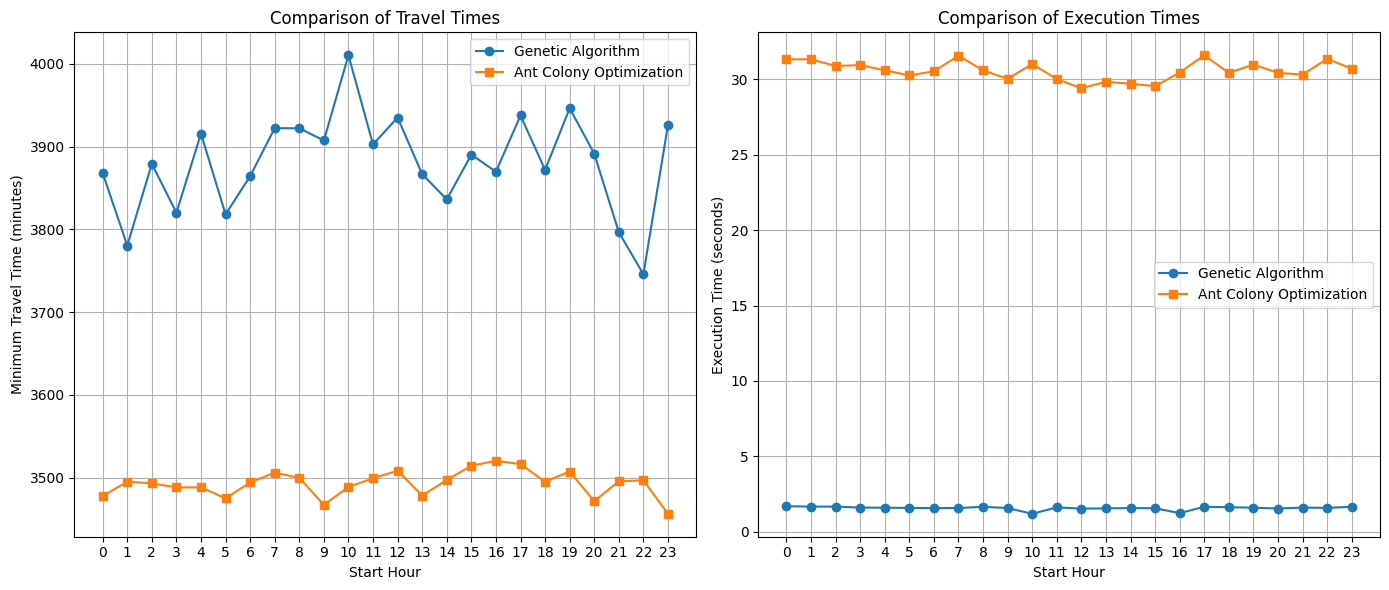

In [152]:
# Visualization of comparison
plt.figure(figsize=(14, 6))

# Travel time comparison
plt.subplot(1, 2, 1)
plt.plot(hours, ga_travel_times, label='Genetic Algorithm', marker='o')
plt.plot(hours, aco_travel_times, label='Ant Colony Optimization', marker='s')
plt.title('Comparison of Travel Times')
plt.xlabel('Start Hour')
plt.ylabel('Minimum Travel Time (minutes)')
plt.xticks(hours)
plt.legend()
plt.grid(True)

# Execution time comparison
plt.subplot(1, 2, 2)
plt.plot(hours, ga_exec_times, label='Genetic Algorithm', marker='o')
plt.plot(hours, aco_exec_times, label='Ant Colony Optimization', marker='s')
plt.title('Comparison of Execution Times')
plt.xlabel('Start Hour')
plt.ylabel('Execution Time (seconds)')
plt.xticks(hours)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [153]:
# Find the minimum travel time and corresponding results for GA
min_ga_time = min(ga_travel_times)
min_ga_index = ga_travel_times.index(min_ga_time)
best_ga_route = ga_results[min_ga_index][0]  # Get the best route from GA results

# Find the minimum travel time and corresponding results for ACO
min_aco_time = min(aco_travel_times)
min_aco_index = aco_travel_times.index(min_aco_time)
best_aco_route = aco_results[min_aco_index][0]  # Get the best route from ACO results

# Print the results
print(f"Genetic Algorithm - Minimum Travel Time: {min_ga_time} minutes")
print(f"Genetic Algorithm - Best Route: {best_ga_route}")
print(f"Genetic Algorithm - Execution Time: {ga_exec_times[min_ga_index]:.2f} seconds")

print(f"Ant Colony Optimization - Minimum Travel Time: {min_aco_time} minutes")
print(f"Ant Colony Optimization - Best Route: {best_aco_route}")
print(f"Ant Colony Optimization - Execution Time: {aco_exec_times[min_aco_index]:.2f} seconds")

Genetic Algorithm - Minimum Travel Time: 3745.8300000000004 minutes
Genetic Algorithm - Best Route: [0, 6, 2, 30, 11, 44, 1, 5, 41, 15, 39, 20, 37, 43, 46, 19, 16, 33, 24, 34, 28, 4, 12, 31, 17, 13, 10, 27, 22, 18, 38, 29, 42, 23, 45, 8, 48, 47, 7, 25, 9, 32, 3, 14, 36, 35, 49, 40, 26, 21, 0]
Genetic Algorithm - Execution Time: 1.57 seconds
Ant Colony Optimization - Minimum Travel Time: 3456.23 minutes
Ant Colony Optimization - Best Route: [0, 21, 47, 30, 2, 6, 20, 41, 3, 16, 23, 34, 33, 24, 4, 29, 26, 40, 22, 18, 5, 1, 17, 31, 8, 45, 38, 46, 19, 25, 7, 44, 36, 14, 28, 15, 39, 35, 37, 49, 43, 27, 10, 42, 12, 13, 11, 32, 9, 48, 0]
Ant Colony Optimization - Execution Time: 30.71 seconds


# Quality Check

In [154]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, PULP_CBC_CMD, LpBinary, value

def solve_tsp_pulp(graph, start_hour):
    num_nodes = len(graph.nodes)
    model = LpProblem("TSP", LpMinimize)

    # Determine if the start hour is within rush hours
    peak_hour = is_rush_hour(start_hour)

    # Create variables for edges
    x = {(i, j): LpVariable(f"x_{i}_{j}", cat=LpBinary) for i in graph.nodes for j in graph.nodes if i != j}

    # Objective function: minimize total travel time with time-dependent weights
    if peak_hour:
        model += lpSum(graph.edges[i, j]['rush_hour_time'] * x[i, j] for i in graph.nodes for j in graph.nodes if i != j)
    else:
        model += lpSum(graph.edges[i, j]['off_peak_time'] * x[i, j] for i in graph.nodes for j in graph.nodes if i != j)

    # Constraints for entering and leaving each node
    for i in graph.nodes:
        if i != 0:  # Depot constraints
            model += lpSum(x[i, j] for j in graph.nodes if i != j) == 1, f"Out_{i}"
            model += lpSum(x[j, i] for j in graph.nodes if i != j) == 1, f"In_{i}"
    
    # Ensure starting and ending at depot (node 0)
    model += lpSum(x[0, j] for j in graph.nodes if j != 0) == 1, "Out_0"
    model += lpSum(x[i, 0] for i in graph.nodes if i != 0) == 1, "In_0"

    # Subtour elimination constraints
    u = {i: LpVariable(f"u_{i}", lowBound=0, upBound=num_nodes - 1) for i in graph.nodes if i != 0}
    
    for i in graph.nodes:
        for j in graph.nodes:
            if i != j and i != 0 and j != 0:
                model += u[i] - u[j] + (num_nodes - 1) * x[i, j] <= num_nodes - 2, f"Subtour_{i}_{j}"

    # Solve the model
    model.solve(PULP_CBC_CMD(msg=0))

    # Extract the solution
    route = []
    for i in graph.nodes:
        for j in graph.nodes:
            if i != j and value(x[i, j]) > 0.5:
                route.append((i, j))

    # Get the order of nodes
    node_sequence = [0]  # Start from node 0
    current_node = 0
    while len(node_sequence) < num_nodes:
        for i, j in route:
            if i == current_node:
                node_sequence.append(j)
                current_node = j
                break

    # Ensure the route ends at depot 0
    node_sequence.append(0)

    return node_sequence, value(model.objective)

In [155]:
import time

# Run PuLP TSP solver for every start hour and compare with GA and ACO
hours = list(range(24))

# Assuming run_genetic_algorithm_comparison and run_ant_colony_optimization_comparison are predefined
comparison_results = {hour: {'PuLP': [], 'GA': [], 'ACO': []} for hour in hours}

for hour in hours:
    # Measure execution time for PuLP solver
    start_time = time.time()
    route_pulp, time_pulp = solve_tsp_pulp(G, start_hour=hour)  # Pass the current hour to consider peak or off-peak
    pulp_exec_time = time.time() - start_time
    comparison_results[hour]['PuLP'].append((route_pulp, time_pulp, pulp_exec_time))

    # Measure execution time for GA
    start_time = time.time()
    ga_route, ga_time, _ = run_genetic_algorithm_comparison(hour)
    ga_exec_time = time.time() - start_time
    comparison_results[hour]['GA'].append((ga_route, ga_time, ga_exec_time))

    # Measure execution time for ACO
    start_time = time.time()
    aco_route, aco_time, _ = run_ant_colony_optimization_comparison(hour)
    aco_exec_time = time.time() - start_time
    comparison_results[hour]['ACO'].append((aco_route, aco_time, aco_exec_time))

    # Print results for current hour
    print(f"Hour {hour}:")
    print(f"PuLP - Route: {route_pulp}, Travel Time: {time_pulp:.2f} minutes, Execution Time: {pulp_exec_time:.2f} seconds")
    print(f"GA   - Route: {ga_route}, Travel Time: {ga_time:.2f} minutes, Execution Time: {ga_exec_time:.2f} seconds")
    print(f"ACO  - Route: {aco_route}, Travel Time: {aco_time:.2f} minutes, Execution Time: {aco_exec_time:.2f} seconds")
    print("-" * 50)


Running Genetic Algorithm for start hour: 0

GA - Start Hour: 0 -> Best Route: [0, 37, 33, 14, 36, 26, 40, 22, 35, 49, 27, 10, 13, 31, 38, 45, 11, 25, 19, 24, 20, 15, 8, 48, 41, 17, 6, 7, 47, 21, 30, 2, 39, 46, 43, 34, 23, 42, 12, 16, 28, 1, 5, 18, 9, 32, 3, 44, 29, 4, 0]
GA - Start Hour: 0 -> Minimum Travel Time: 3797.080000000001 minutes
GA - Execution Time for start hour 0: 1.61 seconds

Running Ant Colony Optimization for start hour: 0

ACO - Start Hour: 0 -> Best Route: [0, 17, 21, 47, 30, 2, 7, 49, 31, 38, 46, 22, 33, 34, 23, 42, 10, 18, 5, 1, 44, 37, 35, 36, 14, 11, 32, 43, 45, 8, 48, 20, 39, 15, 28, 13, 12, 16, 3, 41, 27, 40, 29, 4, 24, 6, 26, 19, 25, 9, 0]
ACO - Start Hour: 0 -> Minimum Travel Time: 3479.9699999999993 minutes
ACO - Execution Time for start hour 0: 30.45 seconds


Hour 0:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.93 seconds
GA   - Route: [0, 37, 33, 14, 36, 26, 40, 22, 35, 49, 27, 10, 13, 31, 38, 45, 11, 25, 19, 24, 20, 15, 8, 48, 41, 17, 6, 7, 47, 21, 30, 2, 39, 46, 43, 34, 23, 42, 12, 16, 28, 1, 5, 18, 9, 32, 3, 44, 29, 4, 0], Travel Time: 3797.08 minutes, Execution Time: 1.61 seconds
ACO  - Route: [0, 17, 21, 47, 30, 2, 7, 49, 31, 38, 46, 22, 33, 34, 23, 42, 10, 18, 5, 1, 44, 37, 35, 36, 14, 11, 32, 43, 45, 8, 48, 20, 39, 15, 28, 13, 12, 16, 3, 41, 27, 40, 29, 4, 24, 6, 26, 19, 25, 9, 0], Travel Time: 3479.97 minutes, Execution Time: 30.45 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 1

GA - Start Hour: 1 -> Best Route: [0, 48, 8, 23, 16, 17, 13, 28, 4, 24, 6, 26, 46, 43, 9, 12, 42, 7, 47, 30, 21, 20, 39, 2, 49, 37, 44, 29, 27, 40, 22, 45, 3, 32, 31, 11, 25, 33, 34, 35, 14, 10, 19, 38, 18, 5, 1, 15, 41, 36, 0]
GA - Start Hour: 1 -> Minimum Travel Time: 3923.7200000000003 minutes
GA - Execution Time for start hour 1: 1.63 seconds

Running Ant Colony Optimization for start hour: 1

ACO - Start Hour: 1 -> Best Route: [0, 48, 8, 27, 4, 24, 33, 34, 23, 21, 47, 30, 2, 7, 44, 1, 5, 18, 25, 19, 20, 6, 17, 45, 43, 46, 38, 31, 11, 13, 10, 42, 29, 37, 49, 16, 12, 35, 39, 22, 40, 26, 36, 14, 28, 15, 41, 3, 32, 9, 0]
ACO - Start Hour: 1 -> Minimum Travel Time: 3499.3199999999993 minutes
ACO - Execution Time for start hour 1: 31.45 seconds


Hour 1:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.86 seconds
GA   - Route: [0, 48, 8, 23, 16, 17, 13, 28, 4, 24, 6, 26, 46, 43, 9, 12, 42, 7, 47, 30, 21, 20, 39, 2, 49, 37, 44, 29, 27, 40, 22, 45, 3, 32, 31, 11, 25, 33, 34, 35, 14, 10, 19, 38, 18, 5, 1, 15, 41, 36, 0], Travel Time: 3923.72 minutes, Execution Time: 1.63 seconds
ACO  - Route: [0, 48, 8, 27, 4, 24, 33, 34, 23, 21, 47, 30, 2, 7, 44, 1, 5, 18, 25, 19, 20, 6, 17, 45, 43, 46, 38, 31, 11, 13, 10, 42, 29, 37, 49, 16, 12, 35, 39, 22, 40, 26, 36, 14, 28, 15, 41, 3, 32, 9, 0], Travel Time: 3499.32 minutes, Execution Time: 31.45 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 2

GA - Start Hour: 2 -> Best Route: [0, 3, 14, 11, 13, 27, 41, 35, 39, 20, 6, 30, 42, 40, 22, 25, 24, 10, 18, 9, 12, 48, 47, 15, 8, 46, 38, 31, 5, 21, 34, 37, 44, 1, 28, 49, 43, 19, 16, 45, 17, 4, 29, 36, 26, 7, 2, 33, 32, 23, 0]
GA - Start Hour: 2 -> Minimum Travel Time: 3917.2799999999997 minutes
GA - Execution Time for start hour 2: 1.63 seconds

Running Ant Colony Optimization for start hour: 2

ACO - Start Hour: 2 -> Best Route: [0, 34, 33, 24, 4, 29, 42, 10, 30, 2, 6, 20, 15, 39, 22, 18, 5, 1, 44, 36, 14, 28, 27, 43, 46, 38, 45, 17, 40, 26, 19, 47, 21, 23, 16, 25, 7, 49, 37, 35, 12, 13, 11, 32, 9, 48, 8, 31, 3, 41, 0]
ACO - Start Hour: 2 -> Minimum Travel Time: 3448.3999999999996 minutes
ACO - Execution Time for start hour 2: 32.87 seconds


Hour 2:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 6.25 seconds
GA   - Route: [0, 3, 14, 11, 13, 27, 41, 35, 39, 20, 6, 30, 42, 40, 22, 25, 24, 10, 18, 9, 12, 48, 47, 15, 8, 46, 38, 31, 5, 21, 34, 37, 44, 1, 28, 49, 43, 19, 16, 45, 17, 4, 29, 36, 26, 7, 2, 33, 32, 23, 0], Travel Time: 3917.28 minutes, Execution Time: 1.63 seconds
ACO  - Route: [0, 34, 33, 24, 4, 29, 42, 10, 30, 2, 6, 20, 15, 39, 22, 18, 5, 1, 44, 36, 14, 28, 27, 43, 46, 38, 45, 17, 40, 26, 19, 47, 21, 23, 16, 25, 7, 49, 37, 35, 12, 13, 11, 32, 9, 48, 8, 31, 3, 41, 0], Travel Time: 3448.40 minutes, Execution Time: 32.87 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 3

GA - Start Hour: 3 -> Best Route: [0, 6, 24, 25, 33, 18, 9, 37, 29, 42, 23, 22, 40, 27, 4, 30, 10, 46, 21, 17, 11, 48, 38, 31, 8, 2, 44, 35, 39, 20, 36, 26, 19, 47, 43, 45, 41, 15, 7, 13, 32, 3, 16, 12, 5, 1, 28, 49, 34, 14, 0]
GA - Start Hour: 3 -> Minimum Travel Time: 3902.6300000000006 minutes
GA - Execution Time for start hour 3: 1.53 seconds

Running Ant Colony Optimization for start hour: 3

ACO - Start Hour: 3 -> Best Route: [0, 4, 29, 32, 11, 13, 12, 16, 3, 41, 15, 49, 28, 14, 36, 35, 9, 1, 37, 40, 26, 46, 22, 33, 2, 30, 47, 21, 23, 34, 6, 31, 38, 19, 25, 27, 10, 42, 44, 7, 43, 45, 8, 48, 20, 39, 24, 18, 5, 17, 0]
ACO - Start Hour: 3 -> Minimum Travel Time: 3494.8199999999997 minutes
ACO - Execution Time for start hour 3: 30.86 seconds


Hour 3:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 6.74 seconds
GA   - Route: [0, 6, 24, 25, 33, 18, 9, 37, 29, 42, 23, 22, 40, 27, 4, 30, 10, 46, 21, 17, 11, 48, 38, 31, 8, 2, 44, 35, 39, 20, 36, 26, 19, 47, 43, 45, 41, 15, 7, 13, 32, 3, 16, 12, 5, 1, 28, 49, 34, 14, 0], Travel Time: 3902.63 minutes, Execution Time: 1.54 seconds
ACO  - Route: [0, 4, 29, 32, 11, 13, 12, 16, 3, 41, 15, 49, 28, 14, 36, 35, 9, 1, 37, 40, 26, 46, 22, 33, 2, 30, 47, 21, 23, 34, 6, 31, 38, 19, 25, 27, 10, 42, 44, 7, 43, 45, 8, 48, 20, 39, 24, 18, 5, 17, 0], Travel Time: 3494.82 minutes, Execution Time: 30.86 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 4

GA - Start Hour: 4 -> Best Route: [0, 9, 10, 13, 17, 45, 31, 38, 24, 6, 37, 47, 16, 3, 14, 28, 22, 42, 29, 27, 41, 2, 39, 15, 40, 19, 26, 7, 43, 46, 12, 4, 30, 21, 23, 18, 1, 5, 8, 44, 11, 25, 33, 32, 20, 48, 34, 49, 35, 36, 0]
GA - Start Hour: 4 -> Minimum Travel Time: 3882.8900000000003 minutes
GA - Execution Time for start hour 4: 1.59 seconds

Running Ant Colony Optimization for start hour: 4

ACO - Start Hour: 4 -> Best Route: [0, 41, 15, 28, 14, 36, 44, 37, 1, 5, 18, 22, 33, 34, 23, 21, 47, 30, 16, 3, 32, 11, 17, 31, 8, 45, 43, 46, 38, 24, 10, 42, 29, 4, 27, 25, 19, 26, 6, 2, 7, 49, 40, 13, 12, 9, 35, 39, 20, 48, 0]
ACO - Start Hour: 4 -> Minimum Travel Time: 3474.83 minutes
ACO - Execution Time for start hour 4: 30.84 seconds


Hour 4:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 6.17 seconds
GA   - Route: [0, 9, 10, 13, 17, 45, 31, 38, 24, 6, 37, 47, 16, 3, 14, 28, 22, 42, 29, 27, 41, 2, 39, 15, 40, 19, 26, 7, 43, 46, 12, 4, 30, 21, 23, 18, 1, 5, 8, 44, 11, 25, 33, 32, 20, 48, 34, 49, 35, 36, 0], Travel Time: 3882.89 minutes, Execution Time: 1.59 seconds
ACO  - Route: [0, 41, 15, 28, 14, 36, 44, 37, 1, 5, 18, 22, 33, 34, 23, 21, 47, 30, 16, 3, 32, 11, 17, 31, 8, 45, 43, 46, 38, 24, 10, 42, 29, 4, 27, 25, 19, 26, 6, 2, 7, 49, 40, 13, 12, 9, 35, 39, 20, 48, 0], Travel Time: 3474.83 minutes, Execution Time: 30.84 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 5

GA - Start Hour: 5 -> Best Route: [0, 41, 27, 28, 13, 4, 24, 18, 10, 30, 42, 8, 45, 29, 47, 16, 26, 46, 6, 17, 5, 22, 39, 2, 21, 37, 49, 43, 7, 1, 44, 36, 23, 34, 48, 38, 31, 11, 14, 3, 12, 25, 33, 40, 19, 20, 15, 32, 35, 9, 0]
GA - Start Hour: 5 -> Minimum Travel Time: 3958.72 minutes
GA - Execution Time for start hour 5: 1.54 seconds

Running Ant Colony Optimization for start hour: 5

ACO - Start Hour: 5 -> Best Route: [0, 36, 26, 6, 2, 7, 47, 21, 23, 34, 33, 22, 46, 43, 45, 17, 40, 29, 27, 25, 19, 38, 31, 8, 48, 9, 32, 3, 41, 15, 20, 37, 44, 1, 5, 18, 16, 12, 13, 11, 30, 10, 42, 4, 24, 39, 35, 49, 28, 14, 0]
ACO - Start Hour: 5 -> Minimum Travel Time: 3454.2199999999993 minutes
ACO - Execution Time for start hour 5: 30.07 seconds


Hour 5:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.82 seconds
GA   - Route: [0, 41, 27, 28, 13, 4, 24, 18, 10, 30, 42, 8, 45, 29, 47, 16, 26, 46, 6, 17, 5, 22, 39, 2, 21, 37, 49, 43, 7, 1, 44, 36, 23, 34, 48, 38, 31, 11, 14, 3, 12, 25, 33, 40, 19, 20, 15, 32, 35, 9, 0], Travel Time: 3958.72 minutes, Execution Time: 1.55 seconds
ACO  - Route: [0, 36, 26, 6, 2, 7, 47, 21, 23, 34, 33, 22, 46, 43, 45, 17, 40, 29, 27, 25, 19, 38, 31, 8, 48, 9, 32, 3, 41, 15, 20, 37, 44, 1, 5, 18, 16, 12, 13, 11, 30, 10, 42, 4, 24, 39, 35, 49, 28, 14, 0], Travel Time: 3454.22 minutes, Execution Time: 30.08 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 6

GA - Start Hour: 6 -> Best Route: [0, 4, 9, 1, 48, 46, 21, 2, 44, 7, 43, 49, 15, 20, 6, 45, 38, 24, 27, 32, 47, 30, 10, 5, 18, 25, 33, 22, 28, 37, 29, 42, 12, 35, 39, 8, 31, 16, 3, 41, 13, 11, 26, 36, 14, 34, 23, 40, 19, 17, 0]
GA - Start Hour: 6 -> Minimum Travel Time: 3874.85 minutes
GA - Execution Time for start hour 6: 1.60 seconds

Running Ant Colony Optimization for start hour: 6

ACO - Start Hour: 6 -> Best Route: [0, 17, 4, 13, 12, 16, 3, 32, 11, 25, 27, 40, 22, 39, 35, 36, 44, 7, 29, 42, 30, 2, 6, 26, 46, 43, 45, 38, 19, 47, 21, 23, 34, 33, 24, 10, 5, 18, 9, 1, 37, 49, 31, 8, 48, 20, 41, 15, 28, 14, 0]
ACO - Start Hour: 6 -> Minimum Travel Time: 3490.7300000000005 minutes
ACO - Execution Time for start hour 6: 30.21 seconds


Hour 6:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.86 seconds
GA   - Route: [0, 4, 9, 1, 48, 46, 21, 2, 44, 7, 43, 49, 15, 20, 6, 45, 38, 24, 27, 32, 47, 30, 10, 5, 18, 25, 33, 22, 28, 37, 29, 42, 12, 35, 39, 8, 31, 16, 3, 41, 13, 11, 26, 36, 14, 34, 23, 40, 19, 17, 0], Travel Time: 3874.85 minutes, Execution Time: 1.60 seconds
ACO  - Route: [0, 17, 4, 13, 12, 16, 3, 32, 11, 25, 27, 40, 22, 39, 35, 36, 44, 7, 29, 42, 30, 2, 6, 26, 46, 43, 45, 38, 19, 47, 21, 23, 34, 33, 24, 10, 5, 18, 9, 1, 37, 49, 31, 8, 48, 20, 41, 15, 28, 14, 0], Travel Time: 3490.73 minutes, Execution Time: 30.21 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 7

GA - Start Hour: 7 -> Best Route: [0, 12, 35, 14, 11, 16, 3, 41, 2, 38, 31, 25, 19, 40, 29, 4, 24, 10, 5, 18, 9, 1, 28, 15, 39, 23, 36, 26, 6, 30, 45, 17, 13, 7, 49, 43, 48, 46, 22, 8, 34, 33, 42, 44, 37, 20, 32, 27, 47, 21, 0]
GA - Start Hour: 7 -> Minimum Travel Time: 3865.4499999999994 minutes
GA - Execution Time for start hour 7: 1.60 seconds

Running Ant Colony Optimization for start hour: 7

ACO - Start Hour: 7 -> Best Route: [0, 21, 47, 30, 10, 24, 39, 22, 46, 38, 48, 8, 45, 43, 19, 25, 18, 5, 1, 9, 4, 42, 44, 37, 29, 40, 27, 28, 7, 2, 33, 34, 23, 16, 49, 31, 3, 41, 15, 20, 6, 26, 36, 14, 11, 32, 35, 12, 13, 17, 0]
ACO - Start Hour: 7 -> Minimum Travel Time: 3538.7 minutes
ACO - Execution Time for start hour 7: 30.43 seconds


Hour 7:
PuLP - Route: [0, 41, 3, 32, 11, 13, 12, 16, 23, 34, 33, 22, 18, 5, 1, 9, 48, 8, 31, 38, 46, 43, 45, 17, 40, 27, 25, 19, 26, 6, 20, 15, 39, 35, 36, 14, 28, 49, 37, 29, 4, 24, 10, 42, 44, 7, 2, 30, 47, 21, 0], Travel Time: 3965.96 minutes, Execution Time: 26.86 seconds
GA   - Route: [0, 12, 35, 14, 11, 16, 3, 41, 2, 38, 31, 25, 19, 40, 29, 4, 24, 10, 5, 18, 9, 1, 28, 15, 39, 23, 36, 26, 6, 30, 45, 17, 13, 7, 49, 43, 48, 46, 22, 8, 34, 33, 42, 44, 37, 20, 32, 27, 47, 21, 0], Travel Time: 3865.45 minutes, Execution Time: 1.60 seconds
ACO  - Route: [0, 21, 47, 30, 10, 24, 39, 22, 46, 38, 48, 8, 45, 43, 19, 25, 18, 5, 1, 9, 4, 42, 44, 37, 29, 40, 27, 28, 7, 2, 33, 34, 23, 16, 49, 31, 3, 41, 15, 20, 6, 26, 36, 14, 11, 32, 35, 12, 13, 17, 0], Travel Time: 3538.70 minutes, Execution Time: 30.44 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 8

GA - Start Hour: 8 -> Best Route: [0, 41, 3, 14, 47, 37, 49, 28, 26, 45, 17, 21, 30, 20, 39, 24, 4, 13, 10, 43, 34, 8, 15, 46, 22, 33, 2, 36, 19, 40, 27, 5, 18, 9, 35, 48, 38, 31, 42, 6, 1, 11, 44, 7, 29, 32, 23, 12, 16, 25, 0]
GA - Start Hour: 8 -> Minimum Travel Time: 3971.7500000000005 minutes
GA - Execution Time for start hour 8: 1.57 seconds

Running Ant Colony Optimization for start hour: 8

ACO - Start Hour: 8 -> Best Route: [0, 21, 34, 33, 22, 46, 43, 32, 3, 16, 12, 13, 11, 25, 18, 5, 1, 17, 40, 26, 36, 14, 28, 27, 41, 15, 49, 35, 39, 20, 19, 47, 30, 2, 7, 44, 37, 29, 4, 9, 48, 8, 45, 38, 31, 6, 24, 10, 42, 23, 0]
ACO - Start Hour: 8 -> Minimum Travel Time: 3510.28 minutes
ACO - Execution Time for start hour 8: 30.26 seconds


Hour 8:
PuLP - Route: [0, 41, 3, 32, 11, 13, 12, 16, 23, 34, 33, 22, 18, 5, 1, 9, 48, 8, 31, 38, 46, 43, 45, 17, 40, 27, 25, 19, 26, 6, 20, 15, 39, 35, 36, 14, 28, 49, 37, 29, 4, 24, 10, 42, 44, 7, 2, 30, 47, 21, 0], Travel Time: 3965.96 minutes, Execution Time: 26.96 seconds
GA   - Route: [0, 41, 3, 14, 47, 37, 49, 28, 26, 45, 17, 21, 30, 20, 39, 24, 4, 13, 10, 43, 34, 8, 15, 46, 22, 33, 2, 36, 19, 40, 27, 5, 18, 9, 35, 48, 38, 31, 42, 6, 1, 11, 44, 7, 29, 32, 23, 12, 16, 25, 0], Travel Time: 3971.75 minutes, Execution Time: 1.57 seconds
ACO  - Route: [0, 21, 34, 33, 22, 46, 43, 32, 3, 16, 12, 13, 11, 25, 18, 5, 1, 17, 40, 26, 36, 14, 28, 27, 41, 15, 49, 35, 39, 20, 19, 47, 30, 2, 7, 44, 37, 29, 4, 9, 48, 8, 45, 38, 31, 6, 24, 10, 42, 23, 0], Travel Time: 3510.28 minutes, Execution Time: 30.26 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 9

GA - Start Hour: 9 -> Best Route: [0, 37, 33, 48, 30, 2, 7, 44, 3, 32, 20, 39, 24, 4, 5, 1, 10, 9, 35, 19, 38, 12, 13, 11, 31, 45, 23, 34, 21, 47, 27, 25, 16, 49, 15, 18, 28, 14, 36, 29, 26, 6, 42, 41, 17, 40, 22, 46, 8, 43, 0]
GA - Start Hour: 9 -> Minimum Travel Time: 3906.9 minutes
GA - Execution Time for start hour 9: 1.57 seconds

Running Ant Colony Optimization for start hour: 9

ACO - Start Hour: 9 -> Best Route: [0, 43, 46, 38, 19, 26, 40, 15, 28, 27, 25, 11, 13, 12, 16, 23, 34, 33, 24, 10, 42, 45, 17, 41, 3, 32, 9, 1, 44, 7, 29, 4, 5, 18, 22, 39, 35, 36, 14, 21, 47, 30, 2, 6, 20, 37, 49, 31, 8, 48, 0]
ACO - Start Hour: 9 -> Minimum Travel Time: 3489.7100000000005 minutes
ACO - Execution Time for start hour 9: 29.90 seconds


Hour 9:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.75 seconds
GA   - Route: [0, 37, 33, 48, 30, 2, 7, 44, 3, 32, 20, 39, 24, 4, 5, 1, 10, 9, 35, 19, 38, 12, 13, 11, 31, 45, 23, 34, 21, 47, 27, 25, 16, 49, 15, 18, 28, 14, 36, 29, 26, 6, 42, 41, 17, 40, 22, 46, 8, 43, 0], Travel Time: 3906.90 minutes, Execution Time: 1.57 seconds
ACO  - Route: [0, 43, 46, 38, 19, 26, 40, 15, 28, 27, 25, 11, 13, 12, 16, 23, 34, 33, 24, 10, 42, 45, 17, 41, 3, 32, 9, 1, 44, 7, 29, 4, 5, 18, 22, 39, 35, 36, 14, 21, 47, 30, 2, 6, 20, 37, 49, 31, 8, 48, 0], Travel Time: 3489.71 minutes, Execution Time: 29.90 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 10

GA - Start Hour: 10 -> Best Route: [0, 43, 7, 13, 34, 33, 2, 6, 26, 46, 48, 38, 19, 16, 31, 45, 8, 15, 49, 28, 1, 5, 10, 42, 30, 47, 21, 23, 12, 4, 24, 27, 3, 32, 11, 44, 37, 29, 14, 36, 35, 39, 22, 18, 9, 25, 20, 40, 17, 41, 0]
GA - Start Hour: 10 -> Minimum Travel Time: 3823.2400000000007 minutes
GA - Execution Time for start hour 10: 1.57 seconds

Running Ant Colony Optimization for start hour: 10

ACO - Start Hour: 10 -> Best Route: [0, 17, 13, 12, 16, 23, 21, 47, 30, 2, 33, 34, 6, 20, 15, 7, 26, 11, 32, 3, 41, 27, 25, 19, 38, 45, 8, 44, 42, 39, 35, 36, 14, 28, 49, 31, 5, 18, 22, 40, 29, 37, 1, 9, 4, 24, 10, 46, 43, 48, 0]
ACO - Start Hour: 10 -> Minimum Travel Time: 3477.8700000000003 minutes
ACO - Execution Time for start hour 10: 29.73 seconds


Hour 10:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.82 seconds
GA   - Route: [0, 43, 7, 13, 34, 33, 2, 6, 26, 46, 48, 38, 19, 16, 31, 45, 8, 15, 49, 28, 1, 5, 10, 42, 30, 47, 21, 23, 12, 4, 24, 27, 3, 32, 11, 44, 37, 29, 14, 36, 35, 39, 22, 18, 9, 25, 20, 40, 17, 41, 0], Travel Time: 3823.24 minutes, Execution Time: 1.57 seconds
ACO  - Route: [0, 17, 13, 12, 16, 23, 21, 47, 30, 2, 33, 34, 6, 20, 15, 7, 26, 11, 32, 3, 41, 27, 25, 19, 38, 45, 8, 44, 42, 39, 35, 36, 14, 28, 49, 31, 5, 18, 22, 40, 29, 37, 1, 9, 4, 24, 10, 46, 43, 48, 0], Travel Time: 3477.87 minutes, Execution Time: 29.73 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 11

GA - Start Hour: 11 -> Best Route: [0, 48, 30, 8, 34, 35, 44, 7, 13, 28, 1, 37, 2, 32, 11, 25, 9, 42, 45, 29, 26, 36, 14, 6, 18, 22, 23, 21, 46, 19, 43, 47, 20, 15, 39, 12, 4, 5, 41, 17, 40, 27, 10, 24, 33, 3, 16, 49, 31, 38, 0]
GA - Start Hour: 11 -> Minimum Travel Time: 3905.2599999999998 minutes
GA - Execution Time for start hour 11: 1.61 seconds

Running Ant Colony Optimization for start hour: 11

ACO - Start Hour: 11 -> Best Route: [0, 48, 8, 45, 43, 32, 29, 4, 24, 10, 30, 2, 7, 44, 37, 46, 38, 19, 25, 9, 35, 49, 31, 3, 14, 11, 13, 12, 42, 6, 26, 40, 27, 28, 1, 5, 18, 22, 33, 34, 23, 16, 47, 21, 20, 15, 39, 36, 41, 17, 0]
ACO - Start Hour: 11 -> Minimum Travel Time: 3514.0199999999995 minutes
ACO - Execution Time for start hour 11: 30.33 seconds


Hour 11:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.88 seconds
GA   - Route: [0, 48, 30, 8, 34, 35, 44, 7, 13, 28, 1, 37, 2, 32, 11, 25, 9, 42, 45, 29, 26, 36, 14, 6, 18, 22, 23, 21, 46, 19, 43, 47, 20, 15, 39, 12, 4, 5, 41, 17, 40, 27, 10, 24, 33, 3, 16, 49, 31, 38, 0], Travel Time: 3905.26 minutes, Execution Time: 1.61 seconds
ACO  - Route: [0, 48, 8, 45, 43, 32, 29, 4, 24, 10, 30, 2, 7, 44, 37, 46, 38, 19, 25, 9, 35, 49, 31, 3, 14, 11, 13, 12, 42, 6, 26, 40, 27, 28, 1, 5, 18, 22, 33, 34, 23, 16, 47, 21, 20, 15, 39, 36, 41, 17, 0], Travel Time: 3514.02 minutes, Execution Time: 30.33 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 12

GA - Start Hour: 12 -> Best Route: [0, 21, 37, 2, 7, 44, 42, 29, 47, 33, 25, 9, 35, 49, 28, 15, 10, 24, 27, 18, 22, 5, 41, 3, 31, 12, 4, 13, 39, 46, 19, 40, 1, 6, 34, 23, 16, 45, 30, 17, 11, 32, 20, 14, 36, 26, 43, 8, 48, 38, 0]
GA - Start Hour: 12 -> Minimum Travel Time: 3945.7000000000003 minutes
GA - Execution Time for start hour 12: 1.57 seconds

Running Ant Colony Optimization for start hour: 12

ACO - Start Hour: 12 -> Best Route: [0, 6, 20, 48, 8, 34, 23, 16, 12, 13, 11, 14, 36, 35, 37, 29, 42, 10, 24, 4, 9, 32, 3, 31, 49, 7, 44, 1, 28, 27, 25, 19, 26, 40, 17, 45, 38, 46, 43, 5, 18, 22, 33, 39, 15, 41, 2, 30, 47, 21, 0]
ACO - Start Hour: 12 -> Minimum Travel Time: 3462.8 minutes
ACO - Execution Time for start hour 12: 29.97 seconds


Hour 12:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.80 seconds
GA   - Route: [0, 21, 37, 2, 7, 44, 42, 29, 47, 33, 25, 9, 35, 49, 28, 15, 10, 24, 27, 18, 22, 5, 41, 3, 31, 12, 4, 13, 39, 46, 19, 40, 1, 6, 34, 23, 16, 45, 30, 17, 11, 32, 20, 14, 36, 26, 43, 8, 48, 38, 0], Travel Time: 3945.70 minutes, Execution Time: 1.57 seconds
ACO  - Route: [0, 6, 20, 48, 8, 34, 23, 16, 12, 13, 11, 14, 36, 35, 37, 29, 42, 10, 24, 4, 9, 32, 3, 31, 49, 7, 44, 1, 28, 27, 25, 19, 26, 40, 17, 45, 38, 46, 43, 5, 18, 22, 33, 39, 15, 41, 2, 30, 47, 21, 0], Travel Time: 3462.80 minutes, Execution Time: 29.97 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 13

GA - Start Hour: 13 -> Best Route: [0, 34, 6, 26, 19, 18, 16, 3, 33, 22, 42, 40, 17, 31, 11, 25, 27, 47, 1, 44, 37, 20, 15, 41, 48, 5, 21, 32, 43, 49, 28, 4, 7, 2, 39, 24, 38, 46, 8, 14, 36, 23, 29, 45, 30, 10, 13, 12, 35, 9, 0]
GA - Start Hour: 13 -> Minimum Travel Time: 4017.81 minutes
GA - Execution Time for start hour 13: 1.52 seconds

Running Ant Colony Optimization for start hour: 13

ACO - Start Hour: 13 -> Best Route: [0, 17, 40, 27, 25, 19, 38, 31, 49, 43, 46, 22, 33, 34, 23, 16, 12, 4, 24, 10, 13, 11, 32, 3, 41, 20, 39, 18, 5, 1, 9, 48, 8, 45, 30, 47, 21, 2, 6, 26, 7, 15, 28, 14, 36, 35, 44, 42, 29, 37, 0]
ACO - Start Hour: 13 -> Minimum Travel Time: 3466.25 minutes
ACO - Execution Time for start hour 13: 30.17 seconds


Hour 13:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.83 seconds
GA   - Route: [0, 34, 6, 26, 19, 18, 16, 3, 33, 22, 42, 40, 17, 31, 11, 25, 27, 47, 1, 44, 37, 20, 15, 41, 48, 5, 21, 32, 43, 49, 28, 4, 7, 2, 39, 24, 38, 46, 8, 14, 36, 23, 29, 45, 30, 10, 13, 12, 35, 9, 0], Travel Time: 4017.81 minutes, Execution Time: 1.52 seconds
ACO  - Route: [0, 17, 40, 27, 25, 19, 38, 31, 49, 43, 46, 22, 33, 34, 23, 16, 12, 4, 24, 10, 13, 11, 32, 3, 41, 20, 39, 18, 5, 1, 9, 48, 8, 45, 30, 47, 21, 2, 6, 26, 7, 15, 28, 14, 36, 35, 44, 42, 29, 37, 0], Travel Time: 3466.25 minutes, Execution Time: 30.17 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 14

GA - Start Hour: 14 -> Best Route: [0, 36, 29, 32, 20, 19, 47, 16, 28, 4, 12, 23, 42, 40, 22, 18, 24, 10, 46, 26, 48, 11, 8, 15, 39, 13, 41, 3, 14, 9, 25, 33, 37, 49, 7, 1, 5, 27, 43, 2, 21, 34, 38, 31, 6, 44, 35, 30, 45, 17, 0]
GA - Start Hour: 14 -> Minimum Travel Time: 4023.43 minutes
GA - Execution Time for start hour 14: 1.33 seconds

Running Ant Colony Optimization for start hour: 14

ACO - Start Hour: 14 -> Best Route: [0, 36, 35, 39, 22, 46, 43, 45, 8, 48, 47, 30, 2, 7, 44, 37, 29, 32, 11, 13, 12, 16, 23, 21, 34, 33, 18, 5, 1, 17, 40, 42, 41, 15, 49, 28, 14, 3, 31, 38, 19, 26, 6, 20, 24, 10, 27, 25, 9, 4, 0]
ACO - Start Hour: 14 -> Minimum Travel Time: 3478.0099999999998 minutes
ACO - Execution Time for start hour 14: 30.86 seconds


Hour 14:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.87 seconds
GA   - Route: [0, 36, 29, 32, 20, 19, 47, 16, 28, 4, 12, 23, 42, 40, 22, 18, 24, 10, 46, 26, 48, 11, 8, 15, 39, 13, 41, 3, 14, 9, 25, 33, 37, 49, 7, 1, 5, 27, 43, 2, 21, 34, 38, 31, 6, 44, 35, 30, 45, 17, 0], Travel Time: 4023.43 minutes, Execution Time: 1.33 seconds
ACO  - Route: [0, 36, 35, 39, 22, 46, 43, 45, 8, 48, 47, 30, 2, 7, 44, 37, 29, 32, 11, 13, 12, 16, 23, 21, 34, 33, 18, 5, 1, 17, 40, 42, 41, 15, 49, 28, 14, 3, 31, 38, 19, 26, 6, 20, 24, 10, 27, 25, 9, 4, 0], Travel Time: 3478.01 minutes, Execution Time: 30.87 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 15

GA - Start Hour: 15 -> Best Route: [0, 4, 5, 47, 14, 36, 37, 49, 28, 1, 44, 29, 7, 25, 27, 13, 11, 17, 31, 6, 45, 38, 30, 2, 21, 23, 42, 40, 22, 46, 43, 8, 48, 34, 35, 39, 18, 15, 33, 10, 24, 20, 19, 26, 16, 41, 3, 32, 9, 12, 0]
GA - Start Hour: 15 -> Minimum Travel Time: 3811.2599999999998 minutes
GA - Execution Time for start hour 15: 1.54 seconds

Running Ant Colony Optimization for start hour: 15

ACO - Start Hour: 15 -> Best Route: [0, 21, 47, 30, 2, 6, 26, 40, 17, 1, 44, 7, 15, 28, 5, 18, 22, 39, 20, 24, 4, 29, 37, 49, 35, 9, 32, 11, 13, 10, 42, 12, 16, 33, 34, 23, 45, 43, 46, 48, 8, 31, 38, 19, 25, 27, 41, 3, 14, 36, 0]
ACO - Start Hour: 15 -> Minimum Travel Time: 3515.2000000000003 minutes
ACO - Execution Time for start hour 15: 30.12 seconds


Hour 15:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.86 seconds
GA   - Route: [0, 4, 5, 47, 14, 36, 37, 49, 28, 1, 44, 29, 7, 25, 27, 13, 11, 17, 31, 6, 45, 38, 30, 2, 21, 23, 42, 40, 22, 46, 43, 8, 48, 34, 35, 39, 18, 15, 33, 10, 24, 20, 19, 26, 16, 41, 3, 32, 9, 12, 0], Travel Time: 3811.26 minutes, Execution Time: 1.54 seconds
ACO  - Route: [0, 21, 47, 30, 2, 6, 26, 40, 17, 1, 44, 7, 15, 28, 5, 18, 22, 39, 20, 24, 4, 29, 37, 49, 35, 9, 32, 11, 13, 10, 42, 12, 16, 33, 34, 23, 45, 43, 46, 48, 8, 31, 38, 19, 25, 27, 41, 3, 14, 36, 0], Travel Time: 3515.20 minutes, Execution Time: 30.12 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 16

GA - Start Hour: 16 -> Best Route: [0, 6, 26, 7, 47, 21, 46, 22, 39, 24, 4, 43, 31, 3, 14, 9, 1, 17, 45, 13, 12, 5, 18, 10, 30, 11, 25, 27, 32, 23, 36, 44, 29, 42, 19, 35, 49, 40, 15, 8, 48, 34, 33, 16, 28, 37, 20, 41, 2, 38, 0]
GA - Start Hour: 16 -> Minimum Travel Time: 3935.0800000000004 minutes
GA - Execution Time for start hour 16: 1.60 seconds

Running Ant Colony Optimization for start hour: 16

ACO - Start Hour: 16 -> Best Route: [0, 48, 46, 43, 49, 35, 36, 26, 7, 15, 41, 3, 16, 23, 34, 33, 22, 40, 17, 45, 38, 31, 8, 44, 42, 4, 29, 37, 1, 28, 13, 12, 9, 32, 11, 14, 6, 2, 30, 10, 24, 39, 20, 19, 25, 27, 18, 5, 47, 21, 0]
ACO - Start Hour: 16 -> Minimum Travel Time: 3518.3699999999994 minutes
ACO - Execution Time for start hour 16: 30.32 seconds


Hour 16:
PuLP - Route: [0, 41, 3, 32, 11, 13, 12, 16, 23, 34, 33, 22, 18, 5, 1, 9, 48, 8, 31, 38, 46, 43, 45, 17, 40, 27, 25, 19, 26, 6, 20, 15, 39, 35, 36, 14, 28, 49, 37, 29, 4, 24, 10, 42, 44, 7, 2, 30, 47, 21, 0], Travel Time: 3965.96 minutes, Execution Time: 26.85 seconds
GA   - Route: [0, 6, 26, 7, 47, 21, 46, 22, 39, 24, 4, 43, 31, 3, 14, 9, 1, 17, 45, 13, 12, 5, 18, 10, 30, 11, 25, 27, 32, 23, 36, 44, 29, 42, 19, 35, 49, 40, 15, 8, 48, 34, 33, 16, 28, 37, 20, 41, 2, 38, 0], Travel Time: 3935.08 minutes, Execution Time: 1.60 seconds
ACO  - Route: [0, 48, 46, 43, 49, 35, 36, 26, 7, 15, 41, 3, 16, 23, 34, 33, 22, 40, 17, 45, 38, 31, 8, 44, 42, 4, 29, 37, 1, 28, 13, 12, 9, 32, 11, 14, 6, 2, 30, 10, 24, 39, 20, 19, 25, 27, 18, 5, 47, 21, 0], Travel Time: 3518.37 minutes, Execution Time: 30.32 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 17

GA - Start Hour: 17 -> Best Route: [0, 12, 13, 19, 25, 18, 5, 22, 42, 30, 2, 39, 15, 20, 23, 47, 1, 17, 31, 11, 48, 8, 43, 32, 35, 36, 44, 29, 7, 49, 37, 9, 10, 46, 24, 33, 34, 6, 14, 28, 4, 27, 40, 26, 16, 3, 41, 45, 38, 21, 0]
GA - Start Hour: 17 -> Minimum Travel Time: 3878.1100000000006 minutes
GA - Execution Time for start hour 17: 1.58 seconds

Running Ant Colony Optimization for start hour: 17

ACO - Start Hour: 17 -> Best Route: [0, 37, 49, 31, 38, 46, 22, 40, 17, 11, 13, 12, 16, 3, 32, 9, 25, 7, 44, 1, 5, 18, 10, 27, 28, 14, 36, 35, 39, 24, 4, 29, 42, 23, 34, 33, 15, 41, 2, 6, 20, 48, 8, 43, 45, 30, 47, 19, 26, 21, 0]
ACO - Start Hour: 17 -> Minimum Travel Time: 3510.2199999999993 minutes
ACO - Execution Time for start hour 17: 30.63 seconds


Hour 17:
PuLP - Route: [0, 41, 3, 32, 11, 13, 12, 16, 23, 34, 33, 22, 18, 5, 1, 9, 48, 8, 31, 38, 46, 43, 45, 17, 40, 27, 25, 19, 26, 6, 20, 15, 39, 35, 36, 14, 28, 49, 37, 29, 4, 24, 10, 42, 44, 7, 2, 30, 47, 21, 0], Travel Time: 3965.96 minutes, Execution Time: 27.00 seconds
GA   - Route: [0, 12, 13, 19, 25, 18, 5, 22, 42, 30, 2, 39, 15, 20, 23, 47, 1, 17, 31, 11, 48, 8, 43, 32, 35, 36, 44, 29, 7, 49, 37, 9, 10, 46, 24, 33, 34, 6, 14, 28, 4, 27, 40, 26, 16, 3, 41, 45, 38, 21, 0], Travel Time: 3878.11 minutes, Execution Time: 1.58 seconds
ACO  - Route: [0, 37, 49, 31, 38, 46, 22, 40, 17, 11, 13, 12, 16, 3, 32, 9, 25, 7, 44, 1, 5, 18, 10, 27, 28, 14, 36, 35, 39, 24, 4, 29, 42, 23, 34, 33, 15, 41, 2, 6, 20, 48, 8, 43, 45, 30, 47, 19, 26, 21, 0], Travel Time: 3510.22 minutes, Execution Time: 30.63 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 18

GA - Start Hour: 18 -> Best Route: [0, 4, 24, 10, 42, 30, 21, 17, 40, 37, 1, 2, 6, 46, 26, 36, 14, 34, 23, 33, 22, 45, 16, 47, 29, 20, 41, 28, 15, 39, 13, 27, 18, 5, 31, 44, 8, 48, 9, 32, 3, 7, 25, 11, 38, 19, 43, 49, 35, 12, 0]
GA - Start Hour: 18 -> Minimum Travel Time: 3887.64 minutes
GA - Execution Time for start hour 18: 1.57 seconds

Running Ant Colony Optimization for start hour: 18

ACO - Start Hour: 18 -> Best Route: [0, 21, 47, 30, 10, 46, 43, 45, 8, 48, 35, 49, 28, 1, 5, 18, 22, 33, 34, 23, 16, 3, 32, 11, 14, 36, 26, 6, 2, 7, 44, 42, 29, 40, 27, 25, 9, 4, 24, 39, 13, 12, 37, 20, 41, 15, 31, 38, 19, 17, 0]
ACO - Start Hour: 18 -> Minimum Travel Time: 3491.0000000000005 minutes
ACO - Execution Time for start hour 18: 30.25 seconds


Hour 18:
PuLP - Route: [0, 41, 3, 32, 11, 13, 12, 16, 23, 34, 33, 22, 18, 5, 1, 9, 48, 8, 31, 38, 46, 43, 45, 17, 40, 27, 25, 19, 26, 6, 20, 15, 39, 35, 36, 14, 28, 49, 37, 29, 4, 24, 10, 42, 44, 7, 2, 30, 47, 21, 0], Travel Time: 3965.96 minutes, Execution Time: 27.01 seconds
GA   - Route: [0, 4, 24, 10, 42, 30, 21, 17, 40, 37, 1, 2, 6, 46, 26, 36, 14, 34, 23, 33, 22, 45, 16, 47, 29, 20, 41, 28, 15, 39, 13, 27, 18, 5, 31, 44, 8, 48, 9, 32, 3, 7, 25, 11, 38, 19, 43, 49, 35, 12, 0], Travel Time: 3887.64 minutes, Execution Time: 1.57 seconds
ACO  - Route: [0, 21, 47, 30, 10, 46, 43, 45, 8, 48, 35, 49, 28, 1, 5, 18, 22, 33, 34, 23, 16, 3, 32, 11, 14, 36, 26, 6, 2, 7, 44, 42, 29, 40, 27, 25, 9, 4, 24, 39, 13, 12, 37, 20, 41, 15, 31, 38, 19, 17, 0], Travel Time: 3491.00 minutes, Execution Time: 30.25 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 19

GA - Start Hour: 19 -> Best Route: [0, 24, 10, 42, 40, 17, 41, 2, 1, 9, 12, 4, 37, 49, 43, 7, 47, 19, 36, 35, 34, 23, 21, 30, 38, 31, 5, 8, 48, 11, 44, 6, 26, 46, 22, 33, 18, 39, 15, 28, 14, 3, 13, 27, 25, 16, 45, 29, 32, 20, 0]
GA - Start Hour: 19 -> Minimum Travel Time: 3903.2999999999997 minutes
GA - Execution Time for start hour 19: 1.63 seconds

Running Ant Colony Optimization for start hour: 19

ACO - Start Hour: 19 -> Best Route: [0, 21, 47, 30, 2, 7, 44, 1, 9, 18, 5, 10, 24, 33, 34, 23, 16, 12, 42, 4, 29, 37, 35, 49, 28, 27, 25, 19, 26, 40, 22, 46, 43, 45, 38, 31, 8, 48, 20, 15, 39, 13, 17, 11, 32, 3, 41, 36, 14, 6, 0]
ACO - Start Hour: 19 -> Minimum Travel Time: 3473.2400000000002 minutes
ACO - Execution Time for start hour 19: 30.45 seconds


Hour 19:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.84 seconds
GA   - Route: [0, 24, 10, 42, 40, 17, 41, 2, 1, 9, 12, 4, 37, 49, 43, 7, 47, 19, 36, 35, 34, 23, 21, 30, 38, 31, 5, 8, 48, 11, 44, 6, 26, 46, 22, 33, 18, 39, 15, 28, 14, 3, 13, 27, 25, 16, 45, 29, 32, 20, 0], Travel Time: 3903.30 minutes, Execution Time: 1.63 seconds
ACO  - Route: [0, 21, 47, 30, 2, 7, 44, 1, 9, 18, 5, 10, 24, 33, 34, 23, 16, 12, 42, 4, 29, 37, 35, 49, 28, 27, 25, 19, 26, 40, 22, 46, 43, 45, 38, 31, 8, 48, 20, 15, 39, 13, 17, 11, 32, 3, 41, 36, 14, 6, 0], Travel Time: 3473.24 minutes, Execution Time: 30.45 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 20

GA - Start Hour: 20 -> Best Route: [0, 3, 16, 30, 42, 19, 36, 26, 14, 28, 49, 37, 40, 22, 46, 38, 31, 45, 43, 10, 5, 4, 32, 20, 24, 34, 8, 2, 6, 1, 48, 11, 17, 21, 47, 7, 18, 9, 35, 44, 29, 13, 12, 41, 27, 25, 33, 15, 39, 23, 0]
GA - Start Hour: 20 -> Minimum Travel Time: 3915.17 minutes
GA - Execution Time for start hour 20: 1.54 seconds

Running Ant Colony Optimization for start hour: 20

ACO - Start Hour: 20 -> Best Route: [0, 41, 3, 44, 7, 2, 30, 47, 21, 23, 16, 12, 13, 11, 32, 29, 4, 24, 10, 42, 40, 17, 45, 8, 48, 20, 15, 39, 35, 49, 28, 27, 25, 9, 1, 5, 18, 22, 33, 34, 14, 36, 26, 6, 31, 38, 19, 43, 46, 37, 0]
ACO - Start Hour: 20 -> Minimum Travel Time: 3459.0600000000004 minutes
ACO - Execution Time for start hour 20: 30.26 seconds


Hour 20:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.78 seconds
GA   - Route: [0, 3, 16, 30, 42, 19, 36, 26, 14, 28, 49, 37, 40, 22, 46, 38, 31, 45, 43, 10, 5, 4, 32, 20, 24, 34, 8, 2, 6, 1, 48, 11, 17, 21, 47, 7, 18, 9, 35, 44, 29, 13, 12, 41, 27, 25, 33, 15, 39, 23, 0], Travel Time: 3915.17 minutes, Execution Time: 1.54 seconds
ACO  - Route: [0, 41, 3, 44, 7, 2, 30, 47, 21, 23, 16, 12, 13, 11, 32, 29, 4, 24, 10, 42, 40, 17, 45, 8, 48, 20, 15, 39, 35, 49, 28, 27, 25, 9, 1, 5, 18, 22, 33, 34, 14, 36, 26, 6, 31, 38, 19, 43, 46, 37, 0], Travel Time: 3459.06 minutes, Execution Time: 30.26 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 21

GA - Start Hour: 21 -> Best Route: [0, 45, 8, 43, 10, 46, 21, 20, 48, 1, 7, 15, 27, 25, 11, 44, 2, 41, 3, 32, 4, 9, 18, 38, 34, 6, 31, 16, 47, 30, 40, 17, 12, 23, 5, 14, 36, 35, 49, 37, 28, 22, 33, 39, 13, 29, 42, 24, 19, 26, 0]
GA - Start Hour: 21 -> Minimum Travel Time: 4025.01 minutes
GA - Execution Time for start hour 21: 1.36 seconds

Running Ant Colony Optimization for start hour: 21

ACO - Start Hour: 21 -> Best Route: [0, 17, 40, 22, 46, 26, 19, 25, 27, 28, 49, 35, 12, 13, 11, 14, 36, 44, 1, 37, 29, 32, 9, 48, 8, 45, 43, 10, 5, 18, 16, 23, 21, 47, 30, 2, 7, 15, 41, 3, 31, 38, 24, 39, 20, 6, 34, 33, 42, 4, 0]
ACO - Start Hour: 21 -> Minimum Travel Time: 3514.2799999999997 minutes
ACO - Execution Time for start hour 21: 29.82 seconds


Hour 21:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.77 seconds
GA   - Route: [0, 45, 8, 43, 10, 46, 21, 20, 48, 1, 7, 15, 27, 25, 11, 44, 2, 41, 3, 32, 4, 9, 18, 38, 34, 6, 31, 16, 47, 30, 40, 17, 12, 23, 5, 14, 36, 35, 49, 37, 28, 22, 33, 39, 13, 29, 42, 24, 19, 26, 0], Travel Time: 4025.01 minutes, Execution Time: 1.36 seconds
ACO  - Route: [0, 17, 40, 22, 46, 26, 19, 25, 27, 28, 49, 35, 12, 13, 11, 14, 36, 44, 1, 37, 29, 32, 9, 48, 8, 45, 43, 10, 5, 18, 16, 23, 21, 47, 30, 2, 7, 15, 41, 3, 31, 38, 24, 39, 20, 6, 34, 33, 42, 4, 0], Travel Time: 3514.28 minutes, Execution Time: 29.82 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 22

GA - Start Hour: 22 -> Best Route: [0, 38, 45, 49, 15, 39, 20, 19, 25, 11, 32, 3, 44, 24, 10, 9, 33, 34, 8, 14, 13, 42, 4, 17, 21, 47, 30, 16, 23, 12, 31, 6, 2, 46, 26, 7, 29, 36, 35, 48, 1, 28, 37, 43, 27, 40, 22, 18, 5, 41, 0]
GA - Start Hour: 22 -> Minimum Travel Time: 3855.8899999999994 minutes
GA - Execution Time for start hour 22: 1.56 seconds

Running Ant Colony Optimization for start hour: 22

ACO - Start Hour: 22 -> Best Route: [0, 21, 23, 16, 3, 14, 28, 27, 40, 29, 4, 12, 9, 32, 11, 13, 39, 35, 37, 1, 5, 18, 22, 46, 43, 45, 38, 31, 49, 34, 33, 24, 25, 19, 26, 36, 44, 42, 10, 30, 47, 7, 2, 41, 15, 8, 48, 20, 6, 17, 0]
ACO - Start Hour: 22 -> Minimum Travel Time: 3483.62 minutes
ACO - Execution Time for start hour 22: 30.11 seconds


Hour 22:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.87 seconds
GA   - Route: [0, 38, 45, 49, 15, 39, 20, 19, 25, 11, 32, 3, 44, 24, 10, 9, 33, 34, 8, 14, 13, 42, 4, 17, 21, 47, 30, 16, 23, 12, 31, 6, 2, 46, 26, 7, 29, 36, 35, 48, 1, 28, 37, 43, 27, 40, 22, 18, 5, 41, 0], Travel Time: 3855.89 minutes, Execution Time: 1.56 seconds
ACO  - Route: [0, 21, 23, 16, 3, 14, 28, 27, 40, 29, 4, 12, 9, 32, 11, 13, 39, 35, 37, 1, 5, 18, 22, 46, 43, 45, 38, 31, 49, 34, 33, 24, 25, 19, 26, 36, 44, 42, 10, 30, 47, 7, 2, 41, 15, 8, 48, 20, 6, 17, 0], Travel Time: 3483.62 minutes, Execution Time: 30.12 seconds
--------------------------------------------------



Running Genetic Algorithm for start hour: 23

GA - Start Hour: 23 -> Best Route: [0, 4, 41, 1, 17, 45, 30, 11, 7, 15, 18, 9, 44, 42, 23, 21, 47, 5, 8, 43, 49, 37, 2, 36, 19, 26, 16, 29, 40, 22, 3, 32, 20, 39, 13, 31, 6, 34, 35, 48, 12, 25, 33, 24, 14, 28, 27, 10, 46, 38, 0]
GA - Start Hour: 23 -> Minimum Travel Time: 4008.18 minutes
GA - Execution Time for start hour 23: 1.56 seconds

Running Ant Colony Optimization for start hour: 23

ACO - Start Hour: 23 -> Best Route: [0, 23, 42, 44, 1, 5, 18, 22, 40, 17, 45, 43, 19, 25, 7, 2, 6, 26, 29, 4, 9, 32, 11, 14, 36, 35, 34, 33, 24, 10, 30, 47, 21, 37, 46, 38, 31, 49, 28, 27, 41, 3, 16, 12, 13, 39, 20, 15, 8, 48, 0]
ACO - Start Hour: 23 -> Minimum Travel Time: 3491.71 minutes
ACO - Execution Time for start hour 23: 30.02 seconds


Hour 23:
PuLP - Route: [0, 48, 8, 31, 38, 19, 26, 46, 43, 45, 17, 40, 27, 25, 9, 1, 5, 18, 22, 33, 34, 23, 16, 12, 13, 11, 32, 3, 41, 15, 7, 44, 42, 10, 24, 4, 29, 37, 49, 28, 14, 36, 35, 39, 20, 6, 2, 30, 47, 21, 0], Travel Time: 3198.00 minutes, Execution Time: 5.82 seconds
GA   - Route: [0, 4, 41, 1, 17, 45, 30, 11, 7, 15, 18, 9, 44, 42, 23, 21, 47, 5, 8, 43, 49, 37, 2, 36, 19, 26, 16, 29, 40, 22, 3, 32, 20, 39, 13, 31, 6, 34, 35, 48, 12, 25, 33, 24, 14, 28, 27, 10, 46, 38, 0], Travel Time: 4008.18 minutes, Execution Time: 1.56 seconds
ACO  - Route: [0, 23, 42, 44, 1, 5, 18, 22, 40, 17, 45, 43, 19, 25, 7, 2, 6, 26, 29, 4, 9, 32, 11, 14, 36, 35, 34, 33, 24, 10, 30, 47, 21, 37, 46, 38, 31, 49, 28, 27, 41, 3, 16, 12, 13, 39, 20, 15, 8, 48, 0], Travel Time: 3491.71 minutes, Execution Time: 30.02 seconds
--------------------------------------------------


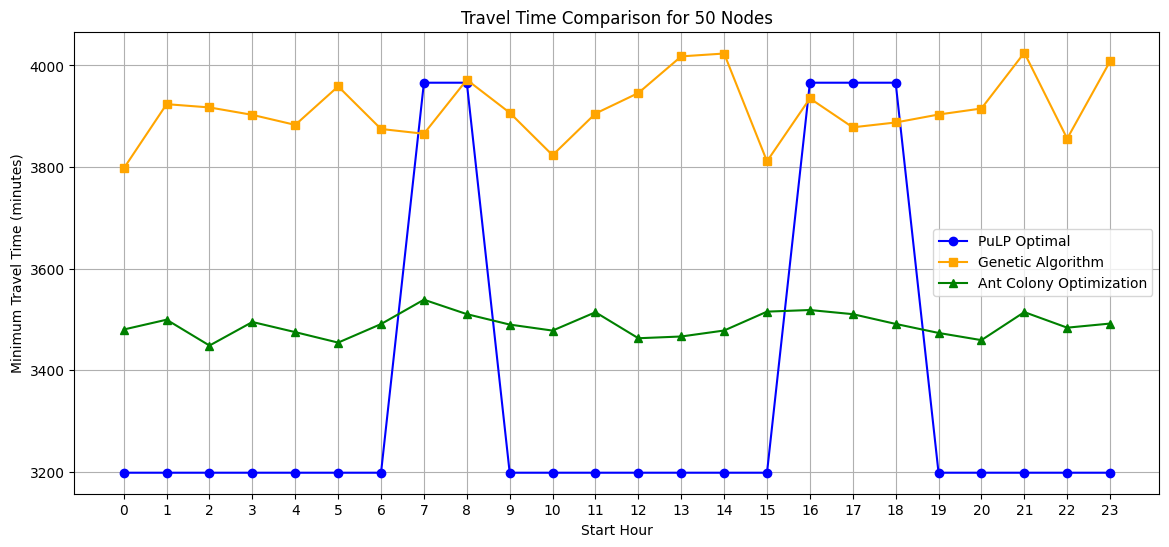

In [156]:
# Visualization for travel time
pulp_times = [comparison_results[hour]['PuLP'][0][1] for hour in hours]
ga_times = [comparison_results[hour]['GA'][0][1] for hour in hours]
aco_times = [comparison_results[hour]['ACO'][0][1] for hour in hours]

plt.figure(figsize=(14, 6))
plt.plot(hours, pulp_times, label='PuLP Optimal', marker='o', color='blue')
plt.plot(hours, ga_times, label='Genetic Algorithm', marker='s', color='orange')
plt.plot(hours, aco_times, label='Ant Colony Optimization', marker='^', color='green')
plt.title('Travel Time Comparison for 50 Nodes')
plt.xlabel('Start Hour')
plt.ylabel('Minimum Travel Time (minutes)')
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.show()

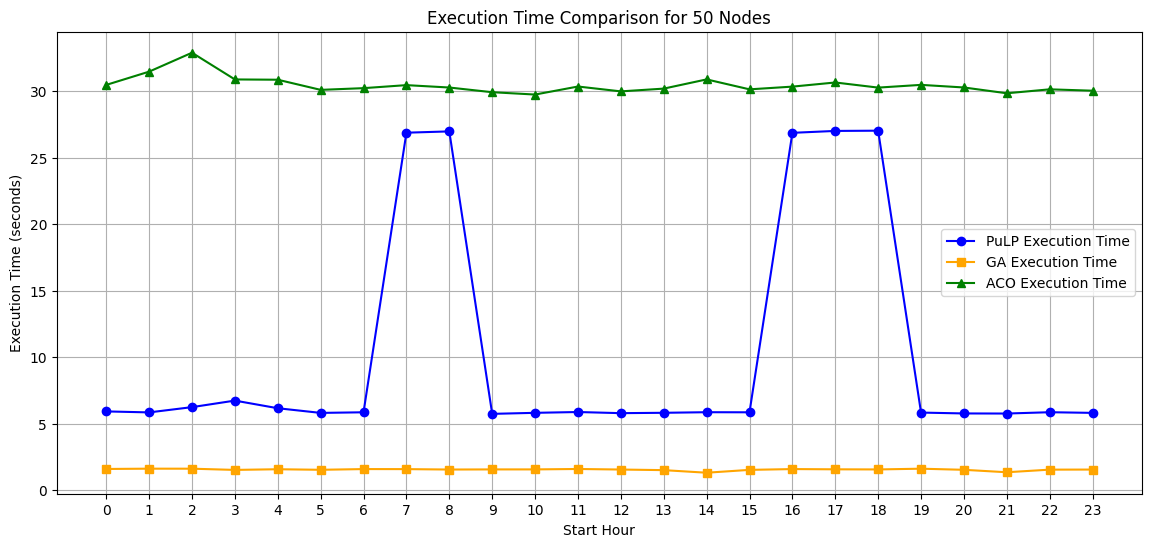

In [157]:
# Visualization for execution time
pulp_exec_times = [comparison_results[hour]['PuLP'][0][2] for hour in hours]
ga_exec_times = [comparison_results[hour]['GA'][0][2] for hour in hours]
aco_exec_times = [comparison_results[hour]['ACO'][0][2] for hour in hours]

plt.figure(figsize=(14, 6))
plt.plot(hours, pulp_exec_times, label='PuLP Execution Time', marker='o', color='blue')
plt.plot(hours, ga_exec_times, label='GA Execution Time', marker='s', color='orange')
plt.plot(hours, aco_exec_times, label='ACO Execution Time', marker='^', color='green')
plt.title('Execution Time Comparison for 50 Nodes')
plt.xlabel('Start Hour')
plt.ylabel('Execution Time (seconds)')
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.show()

In [158]:
optimal_cost = min(pulp_times)
optimal_exec_cost = min(pulp_exec_times)

In [159]:
# Gap calculation Travel Time
ga_gap = ((min_ga_time - optimal_cost) / optimal_cost) * 100
aco_gap = ((min_aco_time - optimal_cost) / optimal_cost) * 100

print("Gap between minimum time taken for a truck to travel 50 cities")
print(f"Optimal Cost: {optimal_cost}")
print(f"GA Cost: {min_ga_time}, Gap: {ga_gap:.2f}%")
print(f"ACO Cost: {min_aco_time}, Gap: {aco_gap:.2f}%")

Gap between minimum time taken for a truck to travel 50 cities
Optimal Cost: 3198.0
GA Cost: 3745.8300000000004, Gap: 17.13%
ACO Cost: 3456.23, Gap: 8.07%


In [160]:
# Gap calculation Execution Time
ga_exec_gap = ((ga_exec_times[min_ga_index] - optimal_exec_cost) / optimal_exec_cost) * 100
aco_exec_gap = ((aco_exec_times[min_aco_index] - optimal_exec_cost) / optimal_exec_cost) * 100

print("Gap between execution times when truck travels 50 cities")
print(f"Optimal Cost: {optimal_exec_cost}")
print(f"GA Cost: {ga_exec_times[min_ga_index]}, Gap: {ga_exec_gap:.2f}%")
print(f"ACO Cost: {aco_exec_times[min_aco_index]}, Gap: {aco_exec_gap:.2f}%")

Gap between execution times when truck travels 50 cities
Optimal Cost: 5.746546030044556
GA Cost: 1.5569870471954346, Gap: -72.91%
ACO Cost: 30.0167396068573, Gap: 422.34%


# Understanding the Graphs:

## Travel Time Comparison for 50 Nodes:

**Hypothesis:**
The observed differences in travel time performance between the three optimization algorithms can be attributed to their underlying methodologies and the way they approach the optimization problem.

1. PuLP Optimal:
   - The PuLP Optimal algorithm uses a more rigorous mathematical optimization approach - linear programming.
   - During off-peak hours, when there is less network congestion, the PuLP Optimal algorithm can effectively find the globally optimal routing solutions, leading to the lower bound in travel time.
   - However, during peak hours, the complex mathematical formulations of the PuLP Optimal algorithm struggles to keep up with the rapidly changing network conditions, resulting in suboptimal solutions and higher travel times.

2. Genetic Algorithm:
   - The Genetic Algorithm is a metaheuristic optimization method that mimics the process of natural evolution.
   - It is known for its ability to effectively explore the solution space and find good-quality solutions, even in complex and dynamic environments.
   - The Genetic Algorithm's inherent adaptability to changing network conditions allows it to maintain a more consistent performance throughout the day, without experiencing significant spikes in travel time during peak hours.

3. Ant Colony Optimization:
   - The Ant Colony Optimization algorithm is also a metaheuristic method that is inspired by the foraging behavior of ants.
   - It relies on the indirect communication between individual "ants" (agents) to collectively find optimal paths through the network.
   - This decentralized, iterative approach enables the Ant Colony Optimization algorithm to efficiently navigate the dynamic traffic conditions and provide a relatively stable travel time performance across the different time periods.

## Execution Time Comparison for 50 Nodes:

**Hypothesis:**
The differences in execution time between the three optimization algorithms can be attributed to the inherent complexity and computational requirements of their respective approaches.

1. PuLP Optimal:
   - As mentioned earlier, the PuLP Optimal algorithm employs more complex mathematical optimization techniques.
   - These techniques, while potentially offering optimal solutions, tend to be computationally intensive, especially for larger-scale networks, leading to longer execution times.

2. Genetic Algorithm:
   - The Genetic Algorithm, while still computationally demanding, has a lower execution time compared to the PuLP Optimal approach.
   - This is because the Genetic Algorithm relies on iterative processes, such as selection, crossover, and mutation, which can be parallelized and optimized more effectively than the typically sequential operations of mathematical optimization methods.

3. Ant Colony Optimization:
   - The high execution time of ACO in this case may be due to the specific implementation details, the complexity of the 50-node network, or the algorithm's need to perform a significant amount of pheromone updates and agent coordination to converge to a solution.

*Reference to document named "Quality Check.docx" for comparison on node_size = 10, 15, 25, 50* 